In [3]:
%load_ext autoreload
%reload_ext autoreload
%autoreload 2

import os
import sys
# Add project root to PYTHONPATH
project_root = os.getcwd()
if str(project_root) not in sys.path and project_root.split('/')[-1] == 'chest_ct_retrieval':
    sys.path.append(str(project_root))
elif str(project_root) not in sys.path and project_root.split('/')[-1] == 'notebooks':
    sys.path.append(str(os.path.normpath('/'.join(project_root.split('/')[:-1]))))

%pwd
%cd "E:\\files\\Documents\\Proyecto Proximity\\chest_ct_retrieval"


The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload
E:\files\Documents\Proyecto Proximity\chest_ct_retrieval


In [45]:
import torch
from config.config import load_config
from utils.seed import set_seed
from training.setup import setup_training_run
from training.environment import configure_environment
from eval.metric_loader import load_metrics
from training.data_setup_local import load_dataset, create_loaders
from training.model_setup_local import initialize_model
from training.trainer_local import Trainer


cuda_available = torch.cuda.is_available()

cfg = load_config("config/base_local.yaml")

set_seed(cfg["training"]["seed"])

run_dirs = setup_training_run(cfg["paths"]["dr2156"]["triplet_runs"])

checkpoints_dir = run_dirs["checkpoints"]
tensorboard_dir = run_dirs["logs"]

configure_environment(cfg)

train_set, test_set, neg_compatibles = load_dataset(
    cfg["paths"]["dr2156"]["preprocessed_300_int8"], 
    cfg["training"]["seed"], 
    float(cfg["dataset"]["train_frac"]),
    augmentations_arg=cfg["training"]["augmentations"]
)

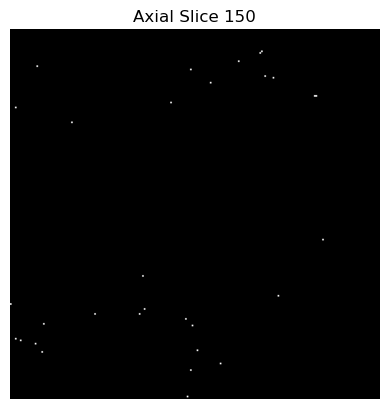

In [55]:
s_vol, s_label = train_set[4]

import matplotlib.pyplot as plt
import torchio as tio
import numpy as np


resize = tio.Compose([
            #tio.Resize([100, 100, -1], image_interpolation='nearest'),
            tio.RescaleIntensity(out_min_max=(-1000,200))
        ])

tio_image = tio.ScalarImage(tensor=s_vol, affine=np.eye(4))
#tio_image = resize(tio_image)                

s_vol = tio_image['data'][0]           # remove channel dimension → shape: [D, H, W]

# Select middle slice in the axial (transverse) plane → [z, y, x]
z_index = s_vol.shape[2] // 2
axial_slice = s_vol[:, :, z_index]

# Plot
plt.imshow(axial_slice.numpy().astype(np.uint8), cmap='gray')
plt.title(f'Axial Slice {z_index}')
plt.axis('off')
plt.show()


In [13]:
s_vol.shape

(1, 100, 100, 300)

In [ ]:
import torch
from config.config import load_config
from utils.seed import set_seed
from training.setup import setup_training_run
from training.environment import configure_environment
from eval.metric_loader import load_metrics
from training.data_setup_local import load_dataset, create_loaders
from training.model_setup_local import initialize_model_triplets
from training.trainer_local import Trainer


cuda_available = torch.cuda.is_available()

cfg = load_config("config/base_local.yaml")

set_seed(cfg["training"]["seed"])

run_dirs = setup_training_run(cfg["paths"]["dr2156"]["triplet_runs"])

checkpoints_dir = run_dirs["checkpoints"]
tensorboard_dir = run_dirs["logs"]

configure_environment(cfg)

train_set, test_set, neg_compatibles = load_dataset(
    cfg["paths"]["dr2156"]["preprocessed_300_int8"], 
    cfg["training"]["seed"], 
    float(cfg["dataset"]["train_frac"]),
    augmentations_arg=cfg["training"]["augmentations"]
)

p_model, p_loss_fn, p_optimizer, p_scheduler = initialize_model_triplets(
    embedding_size=int(cfg["model"]["embedding_size"]),
    margin=float(cfg["loss"]["margin"]),
    lr=float(cfg["training"]["optimizer"]["lr"]),
    weight_decay=float(cfg["training"]["optimizer"]["weight_decay"]),
    negative_compatibles_dict=neg_compatibles,
    print_interval=int(cfg["logging"]["log_interval"]),
    cuda=cuda_available
)

loaders = create_loaders(
    train_set,
    test_set,
    cfg["training"]["batch"]["n_classes"],
    cfg["training"]["batch"]["n_samples"],
    cuda_available
)

p_metrics = load_metrics(cfg)

trainer = Trainer(
    train_loader=loaders["train_triplet"],
    val_loader=loaders["test_triplet"],
    train_eval_loader=loaders["train_eval"],
    val_eval_loader=loaders["test_eval"],
    train_full_loader=loaders["all_triplet_train"],
    val_full_loader=loaders["all_triplet_test"],
    model=p_model,
    loss_fn=p_loss_fn,
    optimizer=p_optimizer,
    scheduler=p_scheduler,
    n_epochs=cfg["training"]["n_epochs"],
    cuda=cuda_available,
    log_interval=cfg["logging"]["log_interval"],
    checkpoint_dir=checkpoints_dir,
    tensorboard_logs_dir=tensorboard_dir,
    train_full_loader_switch=cfg["training"]["train_full_loader_switch"],
    metrics=p_metrics,
    start_epoch=0,
    accumulation_steps=3
)
trainer.fit()


  0%|          | 0/50 [00:00<?, ?it/s]


### EPOCH 1 START ###


  0%|          | 0/469 [00:00<?, ?it/s]

RuntimeError: CUDA error: out of memory
Compile with `TORCH_USE_CUDA_DSA` to enable device-side assertions.


In [ ]:
del tensor, model, subject  # or any other large variables
import gc
gc.collect()
import torch
torch.cuda.empty_cache()